In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

c:\Users\20193709\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
device = get_default_device()
device

device(type='cpu')

In [4]:
# Define the U-Net architecture for binary segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (upsampling path)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv5 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.dec_upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv7 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

          # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)  # 1x1 convolution for binary segmentation


    def forward(self, x):
        # Encoder (downsampling path)
        enc1 = nn.ReLU()(self.enc_conv1(x))
        enc2 = nn.ReLU()(self.enc_conv2(enc1))
        enc2_pool = self.enc_pool1(enc2)

        enc3 = nn.ReLU()(self.enc_conv3(enc2_pool))
        enc4 = nn.ReLU()(self.enc_conv4(enc3))
        enc4_pool = self.enc_pool2(enc4)

        enc5 = nn.ReLU()(self.enc_conv5(enc4_pool))
        enc6 = nn.ReLU()(self.enc_conv6(enc5))
        enc6_pool = self.enc_pool3(enc6)

        enc7 = nn.ReLU()(self.enc_conv7(enc6_pool))
        enc8 = nn.ReLU()(self.enc_conv8(enc7))
        enc8_pool = self.enc_pool4(enc8)

        # Bottleneck
        bottleneck = nn.ReLU()(self.bottleneck_conv1(enc8_pool))
        bottleneck = nn.ReLU()(self.bottleneck_conv2(bottleneck))

        # Decoder (upsampling path)
        dec1 = self.dec_upsample1(bottleneck)
        dec1 = torch.cat([dec1, enc8], dim=1)
        dec1 = nn.ReLU()(self.dec_conv1(dec1))
        dec1 = nn.ReLU()(self.dec_conv2(dec1))

        dec2 = self.dec_upsample2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec2 = nn.ReLU()(self.dec_conv3(dec2))
        dec2 = nn.ReLU()(self.dec_conv4(dec2))

        dec3 = self.dec_upsample3(dec2)
        dec3 = torch.cat([dec3, enc4], dim=1)
        dec3 = nn.ReLU()(self.dec_conv5(dec3))
        dec3 = nn.ReLU()(self.dec_conv6(dec3))

        dec4 = self.dec_upsample4(dec3)
        dec4 = torch.cat([dec4, enc2], dim=1)
        dec4 = nn.ReLU()(self.dec_conv7(dec4))
        dec4 = nn.ReLU()(self.dec_conv8(dec4))

        # Output
        output = self.output_conv(dec4)
        return output   
    
    # Create an instance of the FCN model
model = UNet()

In [5]:
# Define criterion and optimizer
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4414, 0.4456, 0.3421],  # Normalization of real images
    #                         std=[0.2741, 0.2734, 0.3030])
])
transform_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
# In this example, the CustomDataset takes in two lists of file paths: image_list and mask_list, representing the paths to the images and their corresponding masks, 
# respectively. It also takes in an optional transform argument to apply any necessary transformations to the images and masks.
class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, transform_mask=None):
        # self.image_list = image_list
        # self.mask_list = mask_list
        self.image_list = [os.path.join(image_list, f) for f in os.listdir(image_list)]
        self.mask_list = [os.path.join(mask_list, f) for f in os.listdir(mask_list)]
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)
    
    # def binarize_mask(self, mask):
    #     threshold_value = threshold_otsu(mask)
    #     binary_mask = (mask >= threshold_value).astype(int)
    #     return binary_mask

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.convert('L')
        # threshold_value = threshold_otsu(mask)
        # threshold_value = 0.0040  # Adjust the threshold value as needed
        # mask = (np.array(mask) >= threshold_value).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)


        return image, mask

In [8]:
data = CustomDataset('17_06/102_Real/','17_06/102_Mask/', transform=transform, transform_mask=transform_mask)

In [9]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
# Define the data loader
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

len_train = len(train_loader)*batch_size
len_val = len(val_loader)*batch_size

In [11]:
# Mean and STD calculations for real images
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
# for inputs in train_data:#DataLoader(train_data, batch_size=batch_size, shuffle=True):
for i, (images, labels) in enumerate(train_loader):
    psum    += images.sum(axis        = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])
    

# Final Calculation
# pixel count
image_size = 256
count = len_train * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4084, 0.4125, 0.3170])
std:  tensor([0.2865, 0.2865, 0.3031])


In [12]:
import torch

tensor_list = []

for i, (images, labels) in enumerate(train_loader):
    threshold_value = threshold_otsu(labels.squeeze(0).squeeze(0).cpu().numpy())
    binary_mask = (np.array(labels) >= threshold_value).astype(np.float32)
    binary_mask = torch.from_numpy(binary_mask)
    
    tensor_list.append(binary_mask)

# Concatenate the tensors in the list to form one big tensor
big_tensor = torch.cat(tensor_list)

# Compute the mean and standard deviation from the whole tensor
total_mean_mask = torch.mean(big_tensor.float())
total_std_mask = torch.std(big_tensor.float())

print("Mean:", total_mean_mask.item())
print("Standard Deviation:", total_std_mask.item())

Mean: 0.1293376386165619
Standard Deviation: 0.3355732858181


In [13]:
# Redefine Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=total_mean,  # Normalization of real images
                            std=total_std)
])

transform_mask = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=total_mean_mask,  # Normalization of masks
    #                         std=total_std_mask)
])

In [15]:
data = CustomDataset('15_06/102_Real/','15_06/102_Mask/', transform=transform, transform_mask=transform_mask)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

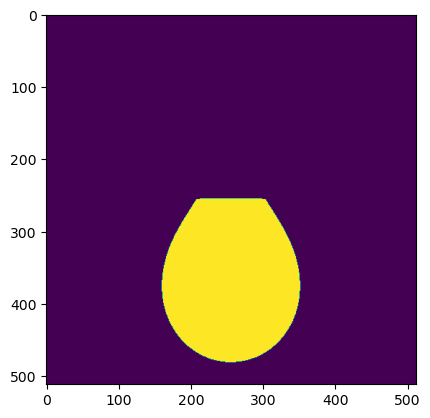

In [16]:
# Check that data is truly binarized
images, labels = data[0]
threshold_value = threshold_otsu(labels.squeeze(0).squeeze(0).cpu().numpy())
binary_mask = (np.array(labels) >= threshold_value).astype(np.float32)
binary_mask = torch.from_numpy(binary_mask)
plt.imshow(binary_mask.squeeze(0))

In [17]:
num_epochs = 10
train_loss_list = []
valid_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)

        threshold_value = threshold_otsu(labels.squeeze(0).squeeze(0).cpu().numpy())
        binary_mask = (np.array(labels) >= threshold_value).astype(np.float32)
        binary_mask = torch.from_numpy(binary_mask)
        
        # Compute the loss
        loss = criterion(outputs, binary_mask)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        # Print the loss every 10 batches
        if i % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            outputs = model(images)

            threshold_value = threshold_otsu(labels.squeeze(0).squeeze(0).cpu().numpy())
            binary_mask = (np.array(labels) >= threshold_value).astype(np.float32)
            binary_mask = torch.from_numpy(binary_mask)
            # Compute the loss
            loss = criterion(outputs, binary_mask)
            
            valid_loss += loss.item()*images.size(0)
            # Accumulate the loss over all batches
            val_loss += loss.item() * images.size(0)
    # Compute the average validation loss
    val_loss /= len(val_data)
      # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] , Val Loss: {val_loss:.4f}')

Epoch [1/10], Batch [1/11], Loss: 0.1232
Epoch [1/10], Batch [2/11], Loss: 0.1146
Epoch [1/10], Batch [3/11], Loss: 249.6318
Epoch [1/10], Batch [4/11], Loss: 0.1131
Epoch [1/10], Batch [5/11], Loss: 0.1161
Epoch [1/10], Batch [6/11], Loss: 0.1171
Epoch [1/10], Batch [7/11], Loss: 0.1174
Epoch [1/10], Batch [8/11], Loss: 0.1178
Epoch [1/10], Batch [9/11], Loss: 0.1174
Epoch [1/10], Batch [10/11], Loss: 0.1181
Epoch [1/10], Batch [11/11], Loss: 0.1159
Epoch [1/10] , Val Loss: 0.1163
Epoch [2/10], Batch [1/11], Loss: 0.1160
Epoch [2/10], Batch [2/11], Loss: 0.1145
Epoch [2/10], Batch [3/11], Loss: 0.1229
Epoch [2/10], Batch [4/11], Loss: 0.1134
Epoch [2/10], Batch [5/11], Loss: 0.1143
Epoch [2/10], Batch [6/11], Loss: 0.1158
Epoch [2/10], Batch [7/11], Loss: 0.1162
Epoch [2/10], Batch [8/11], Loss: 0.1168
Epoch [2/10], Batch [9/11], Loss: 0.1160
Epoch [2/10], Batch [10/11], Loss: 0.1161
Epoch [2/10], Batch [11/11], Loss: 0.1147
Epoch [2/10] , Val Loss: 0.1157
Epoch [3/10], Batch [1/11], 

KeyboardInterrupt: 

In [ ]:
raw_data = {'Train_loss': [train_loss_list],
            'Valid_Loss': [valid_loss_list]}

df = pd.DataFrame(raw_data, columns = ['Train_loss', 'Valid_Loss'])
# Always check/change name for new model
df.to_csv('Losses_binary_102.csv', index=True)

In [ ]:
# plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'Unet_16_06_binary_test.pt')

In [ ]:
# Load model
model = UNet()
model.load_state_dict(torch.load('Unet_13_06_512Test.pt'))

In [ ]:
# Testing model on given outptut
# image_path = "Droplet_XY_val/drop_s40_v5_r0.5_str2_pos2.png"drop_s40_v5_r0.5_str5_pos11.png
image_path = "13_06/512_Real/drop_s32_v5_r0.5_str6_pos0_cam1.png"
# image_path = "syringe-needle-with-droplet-close-up-stuart-minzey.jpg"
image = Image.open(image_path)
image = image.convert('RGB')
# image = image.resize((256,256))
img = transform(image)
img = img.unsqueeze(0)
img.size()

image_mask_path = "13_06/512_Mask/drop_s32_v5_r0.5_str6_pos0_cam1.png"
image_mask = Image.open(image_mask_path)
image_mask = image_mask.convert('RGB')
img_mask = transform_mask(image_mask)
img_mask = img_mask.unsqueeze(0)
img_mask.size()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the trained model and a test image

# Set the model to evaluation mode
model.eval()

# Perform forward pass on the test image
with torch.no_grad():
    output = model(img)  # Assuming you have the test image as a tensor

# Convert the output tensor to a numpy array and squeeze the batch and channel dimensions
output_np = output.squeeze(0).squeeze(0).cpu().numpy()*255

# Apply a threshold to convert the output to a binary mask
# threshold = 0.5  # Adjust the threshold value as needed
mask = (output_np.astype(np.uint8)).T
# mask = mask[0,:,:]
# Plot the original test image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
# Plot the original mask
plt.subplot(1, 3, 2)
plt.imshow(image_mask)
plt.title('Original Mask')
# Plot the generated mask
plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title('Generated Mask')

plt.show()